### Import Required Libraries

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

### Read Data

Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

In [2]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [3]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

__Download the data from [here.](http://www.manythings.org/anki/deu-eng.zip)__ and extract "deu.txt" in your working directory.

In [4]:
!wget -q http://www.manythings.org/anki/deu-eng.zip

In [5]:
!unzip deu-eng.zip

Archive:  deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              


In [6]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [7]:
deu_eng = deu_eng[:50000,:]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [8]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Why did you kiss me?', 'Warum haben Sie mich geküsst?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1482690 (Spamster) & #1482693 (al_ex_an_der)'],
       ['Why did you kiss me?', 'Warum habt ihr mich geküsst?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1482690 (Spamster) & #1482695 (al_ex_an_der)'],
       ['Why did you sell it?', 'Warum hast du es verkauft?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3439456 (CK) & #3610077 (Jan_Schreiber)']],
      dtype='<U537')

We will get rid of the punctuation marks, and then convert the text to lower case.

In [9]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [10]:
deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Why did you kiss me', 'Warum haben Sie mich geküsst',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1482690 (Spamster) & #1482693 (al_ex_an_der)'],
       ['Why did you kiss me', 'Warum habt ihr mich geküsst',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1482690 (Spamster) & #1482695 (al_ex_an_der)'],
       ['Why did you sell it', 'Warum hast du es verkauft',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3439456 (CK) & #3610077 (Jan_Schreiber)']],
      dtype='<U537')

In [11]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()

    deu_eng[i,1] = deu_eng[i,1].lower()

In [12]:
deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['why did you kiss me', 'warum haben sie mich geküsst',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1482690 (Spamster) & #1482693 (al_ex_an_der)'],
       ['why did you kiss me', 'warum habt ihr mich geküsst',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1482690 (Spamster) & #1482695 (al_ex_an_der)'],
       ['why did you sell it', 'warum hast du es verkauft',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3439456 (CK) & #3610077 (Jan_Schreiber)']],
      dtype='<U537')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [13]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [14]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

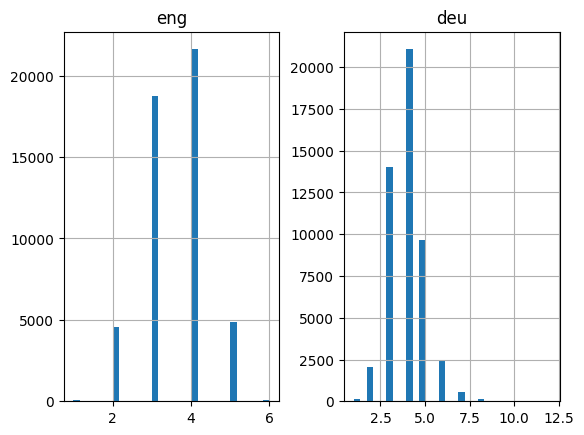

In [15]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [16]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [17]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6133


In [18]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10096


Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above.

In [19]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [20]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [21]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [22]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [23]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [24]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [25]:
filename = 'model.h1.18_Jul_2025.keras'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
          epochs=30, batch_size=512,
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 5.6752
Epoch 1: val_loss improved from inf to 3.01709, saving model to model.h1.18_Jul_2025.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 242ms/step - loss: 5.6514 - val_loss: 3.0171
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 2.8796
Epoch 2: val_loss improved from 3.01709 to 2.73920, saving model to model.h1.18_Jul_2025.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 238ms/step - loss: 2.8787 - val_loss: 2.7392
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 2.6993
Epoch 3: val_loss improved from 2.73920 to 2.67487, saving model to model.h1.18_Jul_2025.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 242ms/step - loss: 2.6991 - val_loss: 2.6749
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 2.6590
Epoch 4: val_loss improved from 2.67487 to 2.65238, saving model to model.h1.18_Jul_2025.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 247ms/step - loss: 2.6588 - val_loss: 2.6524
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step 

Let's compare the training loss and the validation loss.

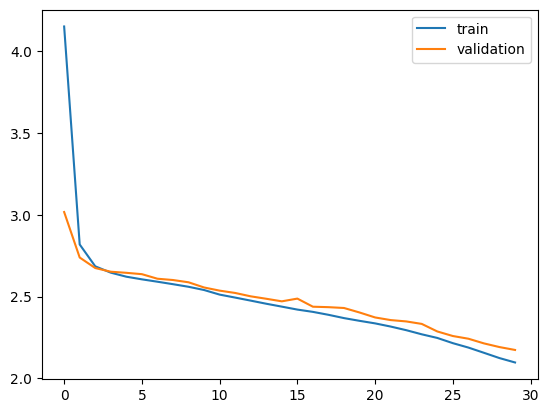

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [27]:
model = load_model('model.h1.18_Jul_2025.keras')
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))
preds = argmax(preds, axis=-1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


In [28]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [29]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)

        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)

    preds_text.append(' '.join(temp))

In [30]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [31]:
pd.set_option('display.max_colwidth', 200)

In [32]:
pred_df.head(15)

,actual,predicted
0,i cant buy a bike,i have to
1,take care,dont it
2,my head hurts,i me my
3,ill buy this,i have a
4,i have tennis elbow,i have a
5,would that be wise,it
6,its already summer,its is
7,did you tell on tom,did tom
8,we want justice,we have
9,have a nice weekend,are it


In [33]:
pred_df.tail(15)

,actual,predicted
9985,tom wasnt funny,tom was a
9986,isnt it boring,this is
9987,im not a stalker,im a
9988,what a lovely day,how was a
9989,stop tickling me,dont the
9990,you wait and see,dont it
9991,tom is a waiter,tom is
9992,step on it,please the
9993,it was very stuffy,it was a
9994,you disgust me,you


In [34]:
pred_df.tail(15)

,actual,predicted
9985,tom wasnt funny,tom was a
9986,isnt it boring,this is
9987,im not a stalker,im a
9988,what a lovely day,how was a
9989,stop tickling me,dont the
9990,you wait and see,dont it
9991,tom is a waiter,tom is
9992,step on it,please the
9993,it was very stuffy,it was a
9994,you disgust me,you


In [35]:
pred_df.sample(15)

,actual,predicted
3844,whats she doing,what you
8145,add a pinch of salt,the
1769,theres more,the
3399,tom looks dubious,tom is a
3252,you were my friend,you a
8047,were enthusiastic,were
2613,i ran after tom,i was tom
1840,its part of life,its is my
3884,are you a musician,are you
1215,youre both crazy,youre you


In [36]:
import pickle

# Save tokenizers
with open('eng_tokenizer.pickle', 'wb') as f:
    pickle.dump(eng_tokenizer, f)

with open('deu_tokenizer.pickle', 'wb') as f:
    pickle.dump(deu_tokenizer, f)

# Save model
model.save('translation_model.h5')